<a href="https://colab.research.google.com/github/Storm00212/SkyAcre/blob/main/Dairy_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()  # Select your dairy_multi_disease_dataset.csv file

Saving dairy_multi_disease_dataset.csv to dairy_multi_disease_dataset.csv


In [ ]:
import pandas as pd
import io

# Replace 'dairy_multi_disease_dataset.csv' with the exact filename if different
df = pd.read_csv(io.BytesIO(uploaded['dairy_multi_disease_dataset.csv']))
#seeing dataset structure
print("Dataset shape:", df.shape)
print("\nDisease label distribution:")
print(df['disease_label'].value_counts().sort_index())

print("\nFirst few rows:")# show dataset
df.head()#1st 5

Dataset shape: (120000, 13)

Disease label distribution:
disease_label
0    84011
1    10754
3        1
4    25234
Name: count, dtype: int64

First few rows:


,cow_id,day,ambient_temp,humidity,THI,body_temp,activity_index,feed_intake_kg,water_intake_l,milk_yield_l,milk_conductivity,scc_index,disease_label
0,1,1,27.490142,62.813497,76.614490,38.682953,1.011676,16.994441,88.262357,19.926198,5.167765,206.521450,0
1,1,2,25.585207,68.829386,74.566875,38.913109,0.984395,17.885238,68.898064,25.355140,5.846647,139.482995,0
2,1,3,27.943066,72.351420,78.553053,38.601165,0.971958,20.456203,62.726561,27.301111,5.598885,166.835388,4
3,1,4,30.569090,53.166354,79.451787,38.288539,0.790478,17.000584,66.393282,21.950857,5.458634,172.899109,4
4,1,5,25.297540,66.007390,73.831214,38.952856,0.940602,18.787450,84.397106,19.484860,5.261041,135.665743,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Features (clinically relevant ones - excluding cow_id and day for modeling)
features = ['ambient_temp','THI',
             'milk_yield_l',
            'milk_conductivity']

# Filter out disease_label with only one sample to avoid stratification error
df_filtered = df[df['disease_label'] != 3].copy()

X = df_filtered[features]
y = df_filtered['disease_label']

# Handle class imbalance with class_weight='balanced'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
#training samples complete

Training samples: 95999
Test samples: 24000


In [ ]:
# Random Forest with balanced class weights (great for imbalanced farm data)
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',  # Helps with rare diseases
    n_jobs=-1
)

rf_model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predictions
y_pred = rf_model.predict(X_test)
# Accuracy evaluation.
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9999583333333333

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16802
           1       1.00      1.00      1.00      2151
           4       1.00      1.00      1.00      5047

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# accuracy/confusion matrix


Confusion Matrix:
[[16802     0     0]
 [    1  2150     0]
 [    0     0  5047]]


Feature Importance:
             feature  importance
1                THI    0.344839
2       milk_yield_l    0.299761
3  milk_conductivity    0.281681
0       ambient_temp    0.073720


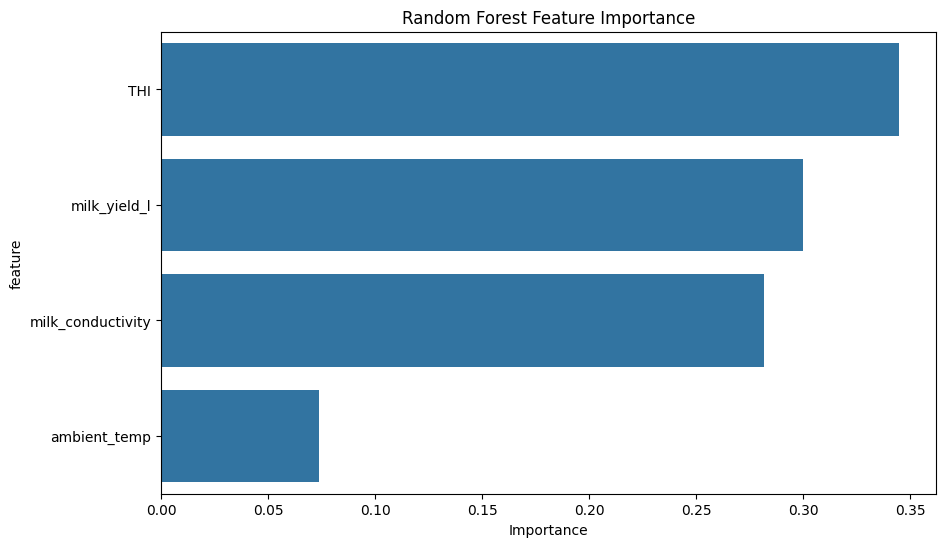

In [ ]:
# Show important features for selection
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_imp)

# Plot for features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()
#will remove less important features

In [ ]:
disease_map = {
    0: "Healthy",
    1: "Subclinical Mastitis",
    2: "Clinical Mastitis",
    3: "Heat Stress"
}


In [ ]:
import numpy as np

# Raw farmer input
input_data = [31, 80, 12, 6.5]

# Convert to numpy & reshape
input_data = np.array(input_data).reshape(1, -1)


In [ ]:
prediction = rf_model.predict(input_data)[0]

predicted_disease = disease_map[prediction]

print(f"Predicted Dairy Condition: {predicted_disease}")
if predicted_disease == "Clinical Mastitis":
    print("Reason: High milk conductivity with significant milk yield drop.")
    print("Action: Isolate cow, consult veterinarian, discard infected milk.")

elif predicted_disease == "Subclinical Mastitis":
    print("Reason: Elevated milk conductivity with early milk yield reduction.")
    print("Action: Improve udder hygiene and monitor cow closely.")

elif predicted_disease == "Heat Stress":
    print("Reason: High temperature and THI affecting productivity.")
    print("Action: Provide shade, clean water, and improve ventilation.")

else:
    print("Cow condition appears normal.")



Predicted Dairy Condition: Subclinical Mastitis
Reason: Elevated milk conductivity with early milk yield reduction.
Action: Improve udder hygiene and monitor cow closely.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# probability prediction
proba = rf_model.predict_proba(input_data)[0]
confidence = np.max(proba) * 100

print(f"Predicted Dairy Condition: {predicted_disease}")
print(f"Confidence: {confidence:.1f}%")
# Added detailed descriptions and recommendations
if predicted_disease == "Clinical Mastitis":
    print("Reason: High milk conductivity with significant milk yield drop.")
    print("Action: Isolate cow, consult veterinarian, discard infected milk.")

elif predicted_disease == "Subclinical Mastitis":
    print("Reason: Elevated milk conductivity with early milk yield reduction.")
    print("Action: Improve udder hygiene and monitor cow closely.")

elif predicted_disease == "Heat Stress":
    print("Reason: High temperature and THI affecting productivity.")
    print("Action: Provide shade, clean water, and improve ventilation.")

else:
    print("Cow condition appears normal.")



Predicted Dairy Condition: Subclinical Mastitis
Confidence: 100.0%
Reason: Elevated milk conductivity with early milk yield reduction.
Action: Improve udder hygiene and monitor cow closely.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
